## Import 

In [29]:
# Import packages 
import pandas as pd
import requests
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter



## Import from EXCEL

In [30]:
# Load each file into its own DataFrame
dc = pd.read_excel("deficitcomptable.FR.xlsx", index_col='period')

dc.index = pd.to_datetime(dc.index, format='%Y')  

pb = pd.read_excel("ProdBrut.FR.xlsx", index_col='period')

pb.index = pd.PeriodIndex(pb.index, freq='Q').to_timestamp()

inn = pd.read_excel("interest.FR.xlsx", index_col='period')
 
inn.index = pd.to_datetime(inn.index, format='%Y')

# Sum the data annually
pb = pb.resample('A').sum()

# index by only year, not full date
pb.index = pb.index.year

dc.index = dc.index.year

inn.index = inn.index.year

#PIB 
PIB = pd.read_excel("PIB.xlsx")



In [31]:

# Keep if country is France
PIB = PIB[PIB['country'].isin(['France'])]

# seperate data by country
PIB = PIB[PIB['country'] == 'France']

# index by year and format to .year
PIB.index = PIB['year']

# Keep only debtgdp
PIB = PIB[[ 'debtgdp']]


In [41]:
# Merge the data by year index
df = pd.merge(pb, dc, left_index=True, right_index=True)
df = pd.merge(df, PIB, left_index=True, right_index=True)
df = pd.merge(df, inn, left_index=True, right_index=True)

In [42]:
# Rename columns
df.columns = ['Produit intérieur brut', 'Capacité (+) ou besoin (-)', 'debtgdp', 'interest']

# Fix units 
df['Produit intérieur brut']=df['Produit intérieur brut']/1000
df['Capacité (+) ou besoin (-)']=df['Capacité (+) ou besoin (-)']/1000
df['interest']=df['interest']/1000

# adjust flux sur PIB
df['dette']=df['debtgdp']*df['Produit intérieur brut']
df['variation dette']=df['dette'].diff()
df['adjust flux']=df['variation dette']-(df['Capacité (+) ou besoin (-)']*-1)
df['adjust flux sur PIB']=(df['adjust flux']/df['Produit intérieur brut'])*100

# deficit sur PIB
df['Deficit sur PIB']=(df['Capacité (+) ou besoin (-)']*-1/df['Produit intérieur brut'])*100

# term plus ASF
df['plus ASF']=(((df['Capacité (+) ou besoin (-)']*-1-df['interest'])/df['Produit intérieur brut'])*100)+df['adjust flux sur PIB']

# term r-g
left = df['Produit intérieur brut'].pct_change()*df['dette']/df['Produit intérieur brut']
right = df['interest']/df['Produit intérieur brut']
df['term r-g'] = (right - left)*100

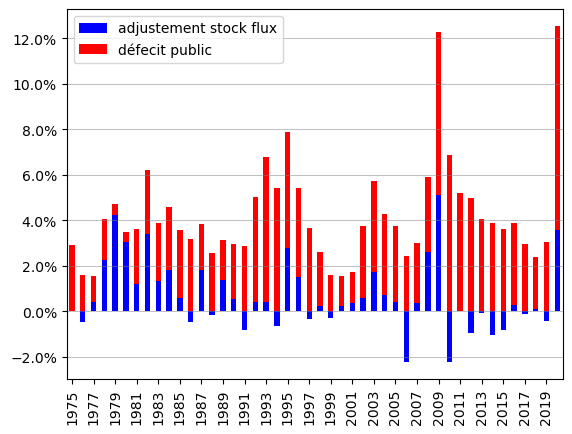

In [43]:
# Assuming df is your DataFrame and it's already imported and prepared
colors = ['blue', 'red']  # Colors for each stack
ax = df[['adjust flux sur PIB', 'Deficit sur PIB']].plot(kind='bar', stacked=True, color=colors)

plt.legend(["adjustement stock flux", "défecit public"])

# Set x-ticks to display every other year
xticks = ax.get_xticks()
# Use list comprehension to decide which ticks labels to show: show labels for even indices
ax.set_xticks(xticks[::2], minor=False)
ax.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
ax.yaxis.set_major_formatter(PercentFormatter(100.0))

plt.show()


## RED Green

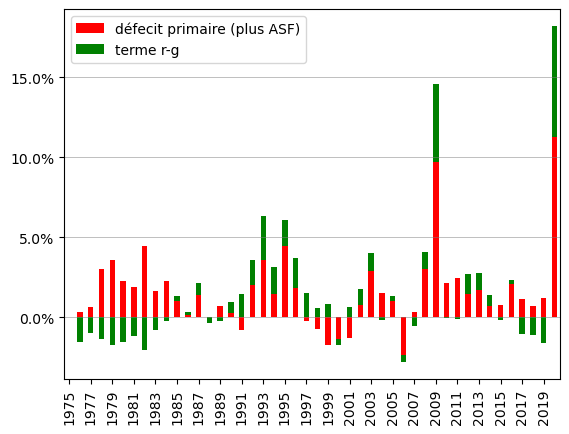

In [44]:
# Assuming df is your DataFrame and it's already imported and prepared
colors = ['red', 'green']  # Red for 'plus ASF', Green for 'term r-g'
ax = df[['plus ASF', 'term r-g']].plot(kind='bar', stacked=True, color=colors)

plt.legend(["défecit primaire (plus ASF)", "terme r-g"])

# Set x-ticks to display every other year
xticks = ax.get_xticks()
# Use list comprehension to decide which ticks labels to show: show labels for even indices
ax.set_xticks(xticks[::2], minor=False)
ax.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
ax.yaxis.set_major_formatter(PercentFormatter(100.0))

plt.show()

